In [1]:
import torch
from torch import nn
from  torch.utils.data import Dataset, DataLoader
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.models import vgg19
from PIL import Image
from torchvision.utils import save_image

In [2]:
from tqdm import tqdm

In [3]:
class ResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels = 64,
            out_channels = 64,
            stride = 1,
            kernel_size = 3,
            padding = 1
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels,
                               out_channels = out_channels,
                               kernel_size = kernel_size,
                               stride = stride,
                               padding= padding,
                               bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = nn.PReLU(num_parameters=out_channels)

        self.conv2 = nn.Conv2d(in_channels = in_channels,
                               out_channels = out_channels,
                               kernel_size = kernel_size,
                               stride = stride,
                               padding= padding,
                               bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + x
        return out


In [4]:
class GeneratorUpsample(nn.Module):
    def __init__(
            self,
            in_channels = 64,
            upsample_value = 2,
            stride = 1,
            kernel_size = 3,
            padding = 1
    ):
        super().__init__()
        self.upsample_value = upsample_value
        self.in_channels = in_channels
        self.stride = stride
        self.kernel_size = kernel_size
        self.padding = padding

        self.conv = nn.Conv2d(in_channels=self.in_channels,
                              out_channels=self.in_channels*upsample_value*upsample_value,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              stride = self.stride)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=upsample_value)
        self.activation = nn.PReLU(in_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.activation(x)
        return x

In [5]:
class Generator(nn.Module):
    def __init__(
            self,
            in_channels = 3,
            out_channels = 3,
            hidden_channels = 64,
            num_res_blocks = 16
    ):
        super().__init__()

        self.in_channels = in_channels
        self.num_res_blocks = num_res_blocks
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels

        self.initial_conv = nn.Conv2d(
            in_channels = self.in_channels,
            out_channels = self.hidden_channels,
            stride = 1,
            kernel_size = 9,
            padding = 4
        )
        self.activation = nn.PReLU(self.hidden_channels)
        self.residual_blocks = nn.Sequential(*[ResidualBlock() for _ in range(num_res_blocks)])
        self.middle_conv = nn.Conv2d(
            in_channels = self.hidden_channels,
            out_channels = self.hidden_channels,
            stride = 1,
            kernel_size = 3,
            padding = 1,
            bias=False
        )
        self.bn = nn.BatchNorm2d(self.hidden_channels)
        self.final_conv = nn.Conv2d(
            in_channels = self.hidden_channels,
            out_channels = self.out_channels,
            stride = 1,
            kernel_size = 9,
            padding = 4
        )
        self.up1 = GeneratorUpsample()
        self.up2 = GeneratorUpsample()


    def forward(self, x):
        x = self.initial_conv(x)
        x = self.activation(x)
        out = self.residual_blocks(x)
        out = self.middle_conv(out)
        out = self.bn(out)
        out = out + x
        out = self.up1(out)
        out = self.up2(out)
        out = self.final_conv(out)
        return out

In [6]:
class ConvBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            stride,
            kernel_size=3,
            padding=1
    ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = out_channels,
                stride = stride,
                kernel_size = kernel_size,
                padding = padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.net(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(
            self,
            in_channels = 3
    ):
        super().__init__()
        self.in_channels = in_channels
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            ConvBlock(in_channels=64, out_channels=64, stride=2),
            ConvBlock(in_channels=64, out_channels=128, stride=1),
            ConvBlock(in_channels=128, out_channels=128, stride=2),
            ConvBlock(in_channels=128, out_channels=256, stride=1),
            ConvBlock(in_channels=256, out_channels=256, stride=2),
            ConvBlock(in_channels=256, out_channels=512, stride=1),
            ConvBlock(in_channels=512, out_channels=512, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=18432, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1)#,
            # nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

In [8]:
class MyDataset(Dataset):
    def __init__(
            self,
            folder_path,
            train = True,
            hr_res = 96
    ):
        super().__init__()
        image_names = os.listdir(path=folder_path)
        self.image_paths = [os.path.join(folder_path, x) for x in image_names]
        self.hr_res = hr_res
        self.lr_res = hr_res//4
        self.initial_transform = A.Compose(
            [
                A.RandomCrop(self.hr_res, self.hr_res),
                A.HorizontalFlip(p=0.5) if train else None,
                A.RandomRotate90(p=0.5) if train else None
            ]
        )
        self.hr_transform = A.Compose(
            [
                A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
                ToTensorV2()
            ]
        )
        self.lr_transform = A.Compose(
            [
                A.Resize(self.lr_res, self.lr_res, interpolation=Image.BICUBIC),
                A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                ToTensorV2()
            ]
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = cv2.imread(self.image_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.initial_transform(image=image)['image']
        hr_image = self.hr_transform(image=image)['image']
        lr_image = self.lr_transform(image=image)['image']
        return hr_image, lr_image

In [9]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
class VGGLoss:
    def __init__(self):
        self.vgg = vgg19().features[:9].eval().to(device)
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.mse = nn.MSELoss()

    def forward(self, x, y):
        real_f = self.vgg(x)
        gen_f = self.vgg(y)
        return self.mse(real_f, gen_f)

In [11]:
def save_example(generator, img_path='finished/valid/dataraw/hires/dt_val_2.jpg'):

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    w = image.shape[0]
    h = image.shape[1]
    lr = A.Compose(
                [
                    A.Resize(w//4, h//4, interpolation=Image.BICUBIC),
                    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    ToTensorV2()
                ]
            )(image=image)['image']
    with torch.no_grad():
        hr = generator(lr.unsqueeze(0).to(device).detach()).cpu()

    save_image(((lr*0.5)+0.5).abs(), 'examples/lr.jpg')
    save_image(hr, 'examples/hr.jpg')

In [12]:
def save_model_checkpoint(model, optimizer, epoch, filename):
    print('saving checkpoint')

    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, filename+f'_{epoch}.pth')

In [13]:
def load_checkpoint(model, optimizer, lr, file):

    global curr_epoch
    print('load checkpoint')
    checkpoint = torch.load(file, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    curr_epoch = checkpoint['epoch']
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [14]:
batch_size = 16

In [15]:
train_dataset = MyDataset(folder_path='finished/train/dataraw/hires', train=True)
test_dataset = MyDataset(folder_path='finished/valid/dataraw/hires', train=False)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

C:\Users\yakub\AppData\Local\Temp\ipykernel_2224\1437425681.py:28: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  A.Resize(self.lr_res, self.lr_res, interpolation=Image.BICUBIC),


In [16]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

### Обучение SRRESNET

In [17]:
NUM_EPOCHS = int(1e6//len(train_dataloader))
learning_rate = 1e-4
srresnet_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.9, 0.999))
mse = nn.MSELoss()
train_losses = []
test_losses = []

In [18]:
preload = True
curr_epoch = 0
if preload:
    load_checkpoint(generator, srresnet_optimizer, learning_rate, 'save_models/srresnet_60.pth')

load checkpoint


In [19]:
curr_epoch

60

In [ ]:
for epoch in range(curr_epoch+1, NUM_EPOCHS):
    print(f'epoch_{epoch}')
    generator.train(True)
    train_loss = 0
    test_loss = 0
    for hr, lr in tqdm(train_dataloader, leave=True):
        hr_gen = generator(lr.to(device))
        loss = mse(hr_gen, hr.to(device))
        generator.zero_grad()
        loss.backward()
        srresnet_optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_dataloader))


    generator.eval()
    for hr, lr in tqdm(test_dataloader, leave=True):
        with torch.no_grad():
            hr_gen = generator(lr.to(device))
            loss = mse(hr_gen, hr.to(device))
            test_loss += loss.item()
    test_losses.append(test_loss/len(test_dataloader))

    if epoch % 1 == 0:
        with torch.no_grad():
            save_example(generator)
    if epoch % 20 == 0:
        save_model_checkpoint(generator, srresnet_optimizer, epoch, 'save_models/srresnet')

epoch_61


100%|██████████| 64/64 [00:13<00:00,  4.85it/s]
C:\Users\yakub\AppData\Local\Temp\ipykernel_2224\4175342338.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  A.Resize(w//4, h//4, interpolation=Image.BICUBIC),


epoch_62


100%|██████████| 64/64 [00:13<00:00,  4.90it/s]


epoch_63


100%|██████████| 64/64 [00:13<00:00,  4.74it/s]


epoch_64


100%|██████████| 64/64 [00:13<00:00,  4.74it/s]


epoch_65


100%|██████████| 64/64 [00:13<00:00,  4.75it/s]


epoch_66


100%|██████████| 64/64 [00:13<00:00,  4.76it/s]


epoch_67


100%|██████████| 64/64 [00:13<00:00,  4.75it/s]


epoch_68


100%|██████████| 64/64 [00:13<00:00,  4.67it/s]


epoch_69


100%|██████████| 64/64 [00:13<00:00,  4.59it/s]


epoch_70


100%|██████████| 64/64 [00:13<00:00,  4.84it/s]


epoch_71


100%|██████████| 64/64 [00:13<00:00,  4.76it/s]


epoch_72


100%|██████████| 64/64 [00:13<00:00,  4.81it/s]


epoch_73


100%|██████████| 64/64 [00:13<00:00,  4.76it/s]


epoch_74


 22%|██▏       | 14/64 [00:02<00:10,  4.84it/s]

In [22]:
import matplotlib.pyplot as  plt

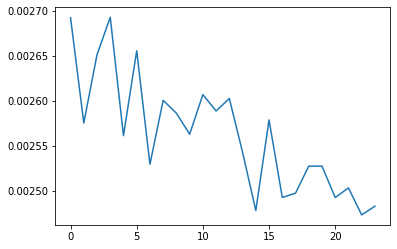

In [25]:
plt.plot(train_losses)

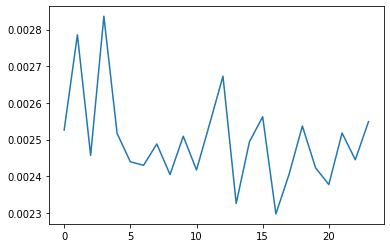

In [26]:
plt.plot(test_losses)

In [213]:
torch.save(generator.state_dict(), 'save_models/srresnet1234.pth')

In [218]:
generator.eval()
with torch.no_grad():
    save_example(generator)

C:\Users\yakub\AppData\Local\Temp\ipykernel_9820\4175342338.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  A.Resize(w//4, h//4, interpolation=Image.BICUBIC),


In [214]:
save_model_checkpoint(generator, srresnet_optimizer, epoch, 'save_models/srresnet')

saving checkpoint


In [215]:
load_checkpoint(generator, srresnet_optimizer, learning_rate, 'save_models/srresnet_5.pth', curr_epoch)

load checkpoint


In [195]:
with torch.no_grad():
    save_example(generator)

C:\Users\yakub\AppData\Local\Temp\ipykernel_9820\3830756034.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  A.Resize(w//4, h//4, interpolation=Image.BICUBIC),


In [179]:
list(generator.parameters())

[Parameter containing:
 tensor([[[[ 6.0688e-02, -4.3723e-02,  4.3832e-02,  ..., -4.8715e-02,
             3.8247e-02, -4.0826e-02],
           [-1.4425e-02, -1.4045e-03,  3.1730e-02,  ..., -4.9534e-02,
             3.7053e-02, -3.4081e-02],
           [-3.8600e-03,  2.4770e-02, -3.8370e-02,  ..., -3.0094e-02,
             8.4406e-03, -2.6750e-02],
           ...,
           [-5.3191e-02,  5.0335e-02,  1.1761e-02,  ...,  3.8625e-04,
            -9.7095e-03,  1.3168e-02],
           [-5.7736e-02, -5.7676e-02, -4.6740e-02,  ...,  2.7844e-02,
            -3.2643e-02,  1.8135e-02],
           [-4.4218e-02,  5.5885e-02,  5.9419e-02,  ...,  5.6561e-02,
             3.9352e-02,  4.0793e-02]],
 
          [[ 5.5931e-03,  1.4943e-02,  4.3907e-02,  ...,  2.8943e-02,
            -1.6683e-02, -5.6615e-02],
           [-1.4969e-02, -2.8429e-02, -5.5707e-02,  ...,  6.1913e-03,
             1.4111e-02,  2.7282e-02],
           [ 5.2486e-02,  1.7700e-02, -3.7962e-02,  ...,  4.5401e-02,
             6.2

In [176]:
list(generator.parameters())

[Parameter containing:
 tensor([[[[ 0.0616, -0.0428,  0.0448,  ..., -0.0481,  0.0389, -0.0403],
           [-0.0137, -0.0007,  0.0325,  ..., -0.0491,  0.0375, -0.0337],
           [-0.0031,  0.0255, -0.0376,  ..., -0.0296,  0.0089, -0.0263],
           ...,
           [-0.0522,  0.0514,  0.0129,  ...,  0.0014, -0.0088,  0.0140],
           [-0.0568, -0.0567, -0.0457,  ...,  0.0287, -0.0319,  0.0188],
           [-0.0435,  0.0567,  0.0603,  ...,  0.0573,  0.0400,  0.0413]],
 
          [[ 0.0065,  0.0158,  0.0448,  ...,  0.0295, -0.0162, -0.0563],
           [-0.0142, -0.0277, -0.0550,  ...,  0.0066,  0.0145,  0.0276],
           [ 0.0533,  0.0184, -0.0372,  ...,  0.0458,  0.0067,  0.0588],
           ...,
           [ 0.0171,  0.0625,  0.0256,  ...,  0.0106, -0.0009, -0.0219],
           [-0.0442, -0.0529,  0.0004,  ...,  0.0060,  0.0287,  0.0140],
           [ 0.0025,  0.0238,  0.0220,  ...,  0.0229, -0.0003, -0.0195]],
 
          [[-0.0219, -0.0432,  0.0416,  ..., -0.0065, -0.0554, 

In [101]:
preload = False
curr_epoch = 0
if preload:
    load_checkpoint(generator, srresnet_optimizer, lr, 'srresnet_0.pth', curr_epoch)

In [104]:
generator.eval()
save_example(generator)

C:\Users\yakub\AppData\Local\Temp\ipykernel_9820\3830756034.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  A.Resize(w//4, h//4, interpolation=Image.BICUBIC),


In [52]:
train_loss

0.059730786830186844

In [49]:
lr.shape

torch.Size([3, 24, 24])

In [19]:
NUM_EPOCHS

3875

In [40]:
save_example()

C:\Users\yakub\AppData\Local\Temp\ipykernel_9820\912244555.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  A.Resize(w//4, h//4, interpolation=Image.BICUBIC),


In [12]:
test_im_path = 'finished/valid/dataraw/hires/dt_val_2.jpg'

In [35]:
image = cv2.imread(test_im_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w = image.shape[0]
h = image.shape[1]
lr = A.Compose(
            [
                A.Resize(w//4, h//4, interpolation=Image.BICUBIC),
                A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                ToTensorV2()
            ]
        )(image=image)['image']
with torch.no_grad():
    hr = generator(lr.unsqueeze(0).to(device).detach()).cpu()

save_image((lr*0.5)+0.5, 'examples/lr.jpg')
save_image(hr, 'examples/hr.jpg')

C:\Users\yakub\AppData\Local\Temp\ipykernel_9820\711043479.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  A.Resize(w//4, h//4, interpolation=Image.BICUBIC),


In [27]:
lr.unsqueeze(0).shape

torch.Size([1, 3, 180, 256])

In [34]:
save_image((lr*0.5)+0.5, 'examples/lr.jpg')

In [32]:
(hr-0)/1

tensor([[[[ 0.0051, -0.0288,  0.0135,  ...,  0.0100, -0.0262,  0.0130],
          [ 0.0246, -0.0207, -0.0157,  ..., -0.0392,  0.0138, -0.0139],
          [-0.0123,  0.0064, -0.0619,  ..., -0.0696, -0.0147, -0.0050],
          ...,
          [-0.0849, -0.0524, -0.0144,  ...,  0.0218,  0.0444, -0.0605],
          [-0.0144, -0.0561, -0.1012,  ..., -0.0437, -0.0642, -0.0665],
          [-0.0151, -0.0429,  0.0163,  ..., -0.1244,  0.0437, -0.0481]],

         [[-0.0562,  0.0451, -0.0742,  ..., -0.0291,  0.0327,  0.0121],
          [-0.0302,  0.0026,  0.0314,  ..., -0.0331,  0.0383,  0.0145],
          [-0.0305, -0.0190, -0.0998,  ...,  0.1033, -0.0119,  0.0552],
          ...,
          [ 0.0654,  0.0494,  0.0656,  ..., -0.0069,  0.0959,  0.0577],
          [ 0.0019, -0.0045,  0.0462,  ...,  0.0348,  0.0380, -0.0067],
          [ 0.0893, -0.0165,  0.0417,  ...,  0.0584, -0.0537,  0.0071]],

         [[ 0.0089,  0.0389, -0.0089,  ..., -0.0248,  0.0333,  0.0344],
          [-0.0483, -0.0154, -

In [27]:
image.shape

(720, 1024, 3)

In [29]:
lr

Compose([
  Resize(always_apply=False, p=1, height=1024, width=720, interpolation=3),
  Normalize(always_apply=False, p=1.0, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [13]:
loss = VGGLoss()

In [18]:
ttt = next(iter(dataset))[0]

In [32]:
loss.forward(next(iter(dataset))[0], next(iter(dataset))[0])

tensor(0.0018)

In [15]:
dataset = MyDataset('finished/train/dataraw/hires')

In [19]:
next(iter(dataset))[1].shape

torch.Size([3, 24, 24])

In [2]:
check = vgg19()

In [6]:
check.features[:9]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
)

In [6]:
os.path.join('finished/train/dataraw/hires', os.listdir('finished/train/dataraw/hires')[0])

'finished/train/dataraw/hires\\dt_train_1.jpg'

In [4]:
os.listdir('finished/train/dataraw/hires')

['dt_train_1.jpg',
 'dt_train_10.jpg',
 'dt_train_100.jpg',
 'dt_train_1000.jpg',
 'dt_train_1001.jpg',
 'dt_train_1002.jpg',
 'dt_train_1003.jpg',
 'dt_train_1004.jpg',
 'dt_train_1005.jpg',
 'dt_train_1006.jpg',
 'dt_train_1007.jpg',
 'dt_train_1008.jpg',
 'dt_train_1009.jpg',
 'dt_train_101.jpg',
 'dt_train_1010.jpg',
 'dt_train_1011.jpg',
 'dt_train_1012.jpg',
 'dt_train_1013.jpg',
 'dt_train_1014.jpg',
 'dt_train_1015.jpg',
 'dt_train_1016.jpg',
 'dt_train_1017.jpg',
 'dt_train_1018.jpg',
 'dt_train_1019.jpg',
 'dt_train_102.jpg',
 'dt_train_1020.jpg',
 'dt_train_1021.jpg',
 'dt_train_1022.jpg',
 'dt_train_1023.jpg',
 'dt_train_1024.jpg',
 'dt_train_1025.jpg',
 'dt_train_1026.jpg',
 'dt_train_1027.jpg',
 'dt_train_1028.jpg',
 'dt_train_1029.jpg',
 'dt_train_103.jpg',
 'dt_train_1030.jpg',
 'dt_train_1031.jpg',
 'dt_train_1032.jpg',
 'dt_train_1033.jpg',
 'dt_train_1034.jpg',
 'dt_train_1035.jpg',
 'dt_train_1036.jpg',
 'dt_train_1037.jpg',
 'dt_train_1038.jpg',
 'dt_train_1039.jpg

In [49]:
Discriminator()(torch.ones(10, 3, 96, 96).float()).shape

torch.Size([10, 1])

In [36]:
gen = Generator()

In [37]:
gen(torch.ones(10, 3, 128, 128)).shape

torch.Size([10, 64, 128, 128])
torch.Size([10, 64, 512, 512])


torch.Size([10, 3, 512, 512])

In [18]:
foo = lambda x, y: x*y
foo(*[2,2])

4

In [15]:
*[ResidualBlock() for x in range(16)]

SyntaxError: can't use starred expression here (3322405202.py, line 1)

In [11]:
up = GeneratorUpsample()

In [12]:
up(torch.ones(10, 64, 128, 128)).shape

torch.Size([10, 64, 256, 256])

In [8]:
ttt = ResidualBlock()

In [4]:
ttt(torch.ones(10, 64, 128, 128)).shape

torch.Size([10, 64, 128, 128])

In [4]:
class ConvBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,

    ):


NameError: name 'self' is not defined

In [2]:
torch.cuda.is_available()

True